In [64]:
import numpy as np
import matplotlib.pyplot as plt
from time import time
from sklearn.utils import check_random_state
from sklearn.metrics import r2_score
from scipy.optimize import fmin_l_bfgs_b
from scipy import stats

import jax
import jax.numpy as jnp

# parameters

In [65]:
m = 10
p = 5
n = 600
max_shift = 20
max_dilation = 1.2
t0 = 0
noise_data = 0.01
noise_model = 1
noise_W_list = 0.01
bounds_factor = 1.2
filter_length = 15
number_of_filters = 1
random_state = 5372111

In [66]:
if max_shift != 0 and max_dilation != 1.:
    dilation_scale = 2 * max_shift / (max_dilation - 1 / max_dilation)
else:
    dilation_scale = 1.

max_dilation_2 = 1 + bounds_factor * (max_dilation - 1)
max_shift_2 = bounds_factor * max_shift

# apply delay functions

In [67]:
def apply_both_delays_1d_cyclic(
    s,
    a,
    b,
    max_shift=0.,
    max_dilation=1.,
    dilation_scale=1.,
    t0=0,
    shift_before_dilation=True,
):
    n = len(s)
    max_delay = (np.ceil((n + max_shift) * max_dilation) - n).astype("int")
    s_extended = jnp.concatenate([s[n-max_delay:], s, s[:max_delay]])
    t_extended = jnp.arange(n + 2 * max_delay) - max_delay - t0
    t = jnp.arange(n) - t0
    if shift_before_dilation:
        t_ab = (t - b) * a / dilation_scale
    else:
        t_ab = t * a / dilation_scale - b
    s_ab = jnp.interp(x=t_ab, xp=t_extended, fp=s_extended, left=0, right=0)
    return s_ab

def apply_both_delays_2d_cyclic(
    S,
    a,
    b,
    max_shift=0.,
    max_dilation=1.,
    dilation_scale=1.,
    t0=0,
    shift_before_dilation=True,
):
    p, n = S.shape
    max_delay = (np.ceil((n + max_shift) * max_dilation) - n).astype("int")
    S_extended = jnp.concatenate([S[:, n-max_delay:], S, S[:, :max_delay]], axis=1)
    t_extended = jnp.arange(n + 2 * max_delay) - max_delay - t0
    t = jnp.arange(n) - t0
    T = jnp.array([t] * p)
    if shift_before_dilation:
        T_ab = ((T.T - b) * a / dilation_scale).T
    else:
        T_ab = (T.T * a / dilation_scale - b).T
    S_ab = jnp.array(
        [jnp.interp(x=T_ab[i], xp=t_extended, fp=S_extended[i], left=0, right=0)
         for i in range(p)])
    return S_ab

def apply_both_delays_3d_cyclic(
    S_list,
    A,
    B,
    max_shift=0.,
    max_dilation=1.,
    dilation_scale=1.,
    t0=0,
    shift_before_dilation=True,
):
    Y_list = jnp.array(
        [apply_both_delays_2d_cyclic(
            S_list[i], a=A[i], b=B[i], max_shift=max_shift, max_dilation=max_dilation, 
            dilation_scale=dilation_scale, t0=t0, shift_before_dilation=shift_before_dilation) 
         for i in range(len(S_list))])
    return Y_list

# generate data

In [68]:
def sources_generation_zero_mean(p, n, rng=None):
    low_mean = n / 4
    high_mean = 6 * n / 10
    means = (np.arange(p) + rng.uniform(size=p)) * (high_mean - low_mean) / p + low_mean
    rng.shuffle(means)
    variances = rng.randint(n // 25, n // 10, size=p)
    heights = rng.uniform(0.6, 1.4, size=p)

    def f(x, mean, var):
        t = (x - mean) / var
        t[t > 0] /= 2
        s = -t/2 * np.exp(-t ** 2)
        s[s < 0] /= 2
        return s

    S = np.array(
        [height * f(np.arange(n), mean, var)
         for height, mean, var in zip(heights, means, variances)])
    return S

def data_generation(
    m,
    p,
    n,
    max_shift=0.,
    max_dilation=1.,
    noise_data=0.05,
    t0=0,
    rng=None,
):
    S = sources_generation_zero_mean(p, n, rng)
    S_list = np.array([S] * m) + noise_data * rng.randn(m, p, n)
    A_list = rng.randn(m, p, p)
    dilations = rng.uniform(low=1/max_dilation, high=max_dilation, size=(m, p))
    shifts = rng.uniform(low=-max_shift, high=max_shift, size=(m, p))
    S_list = apply_both_delays_3d_cyclic(
        S_list, A=dilations, B=shifts, max_shift=max_shift, max_dilation=max_dilation,
        dilation_scale=1., t0=t0)
    X_list = np.array([np.dot(A, S) for A, S in zip(A_list, S_list)])
    return X_list, A_list, dilations, shifts, S_list, S

In [69]:
# generate data
rng = check_random_state(random_state)
X_list, A_list, dilations, shifts, S_list, S = data_generation(
    m=m,
    p=p,
    n=n,
    max_shift=max_shift,
    max_dilation=max_dilation,
    noise_data=noise_data,
    t0=t0,
    rng=rng,
)

# plot data

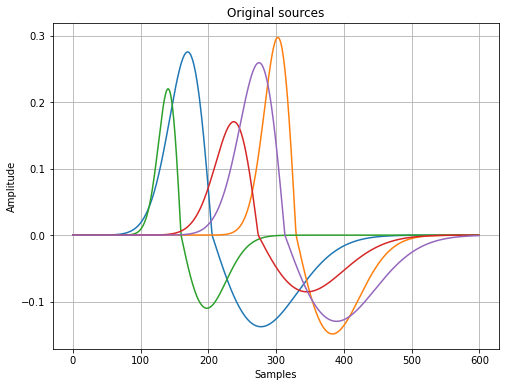

In [70]:
plt.figure(figsize=(8, 6))
plt.plot(S.T)
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.title("Original sources")
plt.grid()
plt.show()

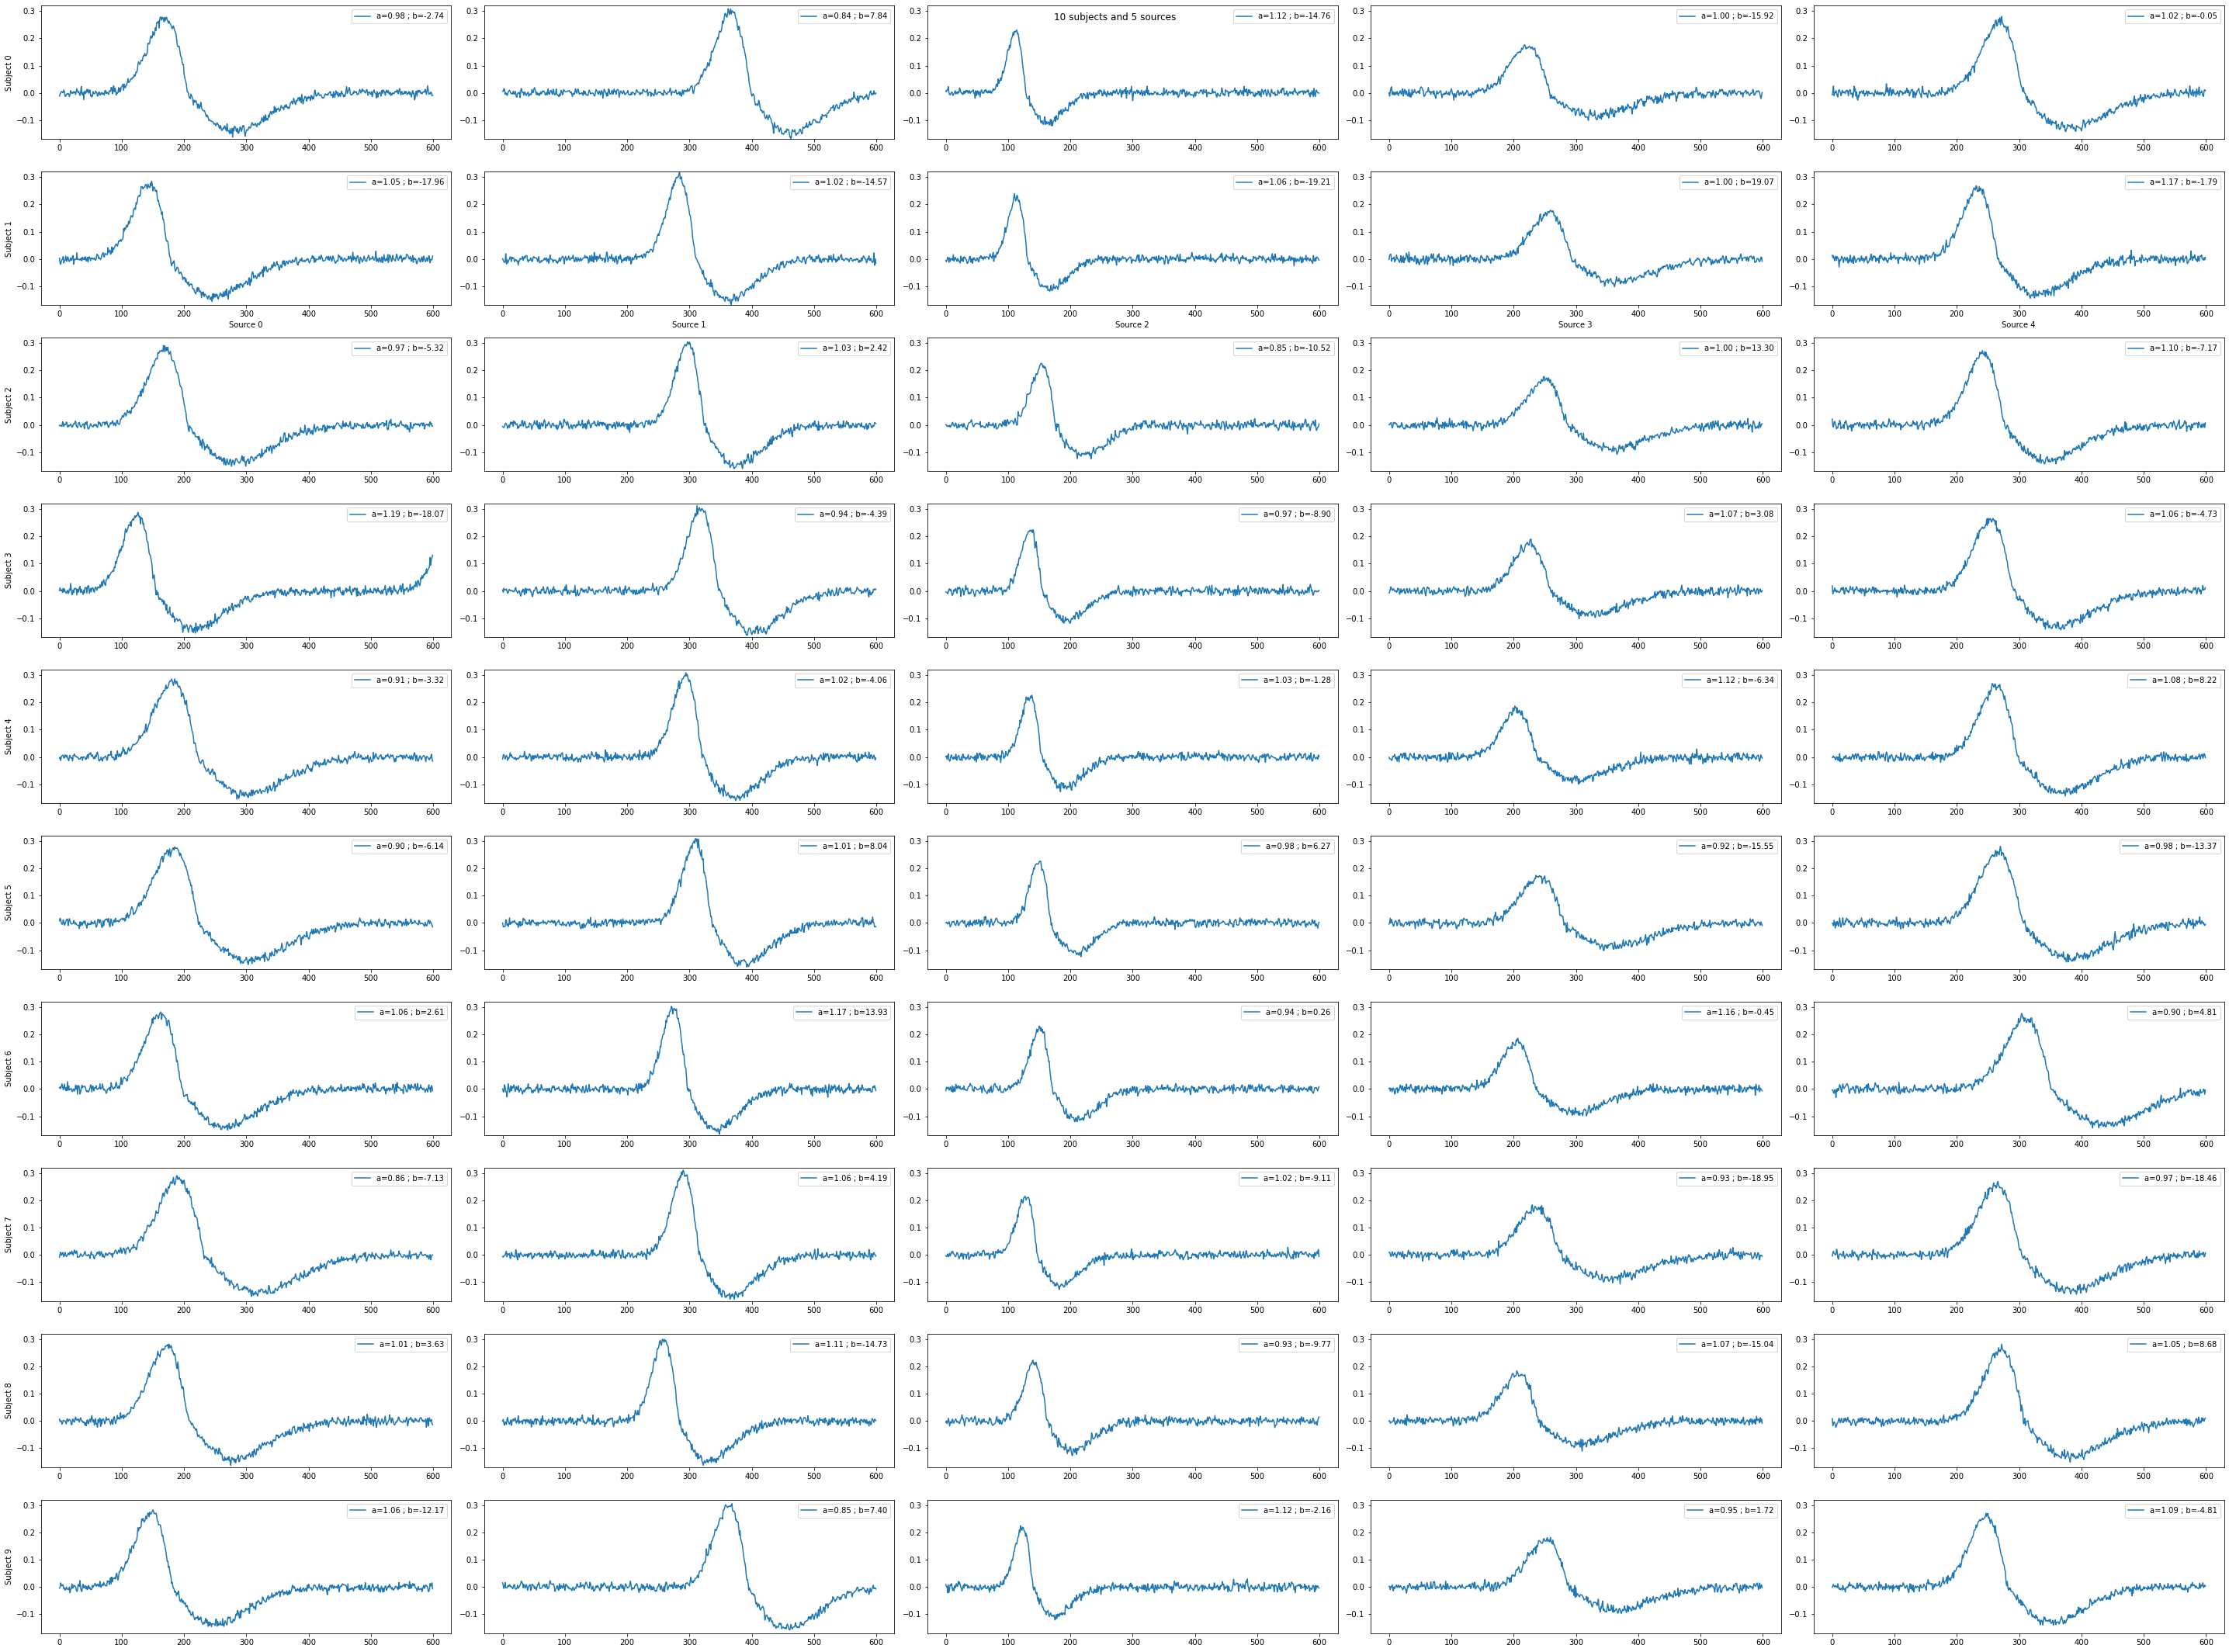

In [71]:
# plot 2 sources of 2 subjects
plt.subplots(m, p, figsize=(4*m, 6*p))

for i in range(m):
    for j in range(p):
        plt.subplot(m, p, p * i + j + 1)
        plt.plot(S_list[i, j], label=f'a={dilations[i, j]:.2f} ; b={shifts[i, j]:.2f}')
        # plt.vlines(x=t0, ymin=np.min(S_list), ymax=np.max(S_list), linestyles='--', colors='grey')
        plt.ylim([np.min(S_list), np.max(S_list)])
        if j == 0:
            plt.ylabel(f"Subject {i}")
        if i == 1:
            plt.xlabel(f"Source {j}")
        plt.legend()
plt.suptitle(f"{m} subjects and {p} sources")
plt.tight_layout()
plt.show()

# loss and grad

In [72]:
jax.config.update('jax_enable_x64', True)

In [73]:
def penalization(A, B, dilation_scale=1.):
    pen_A = jnp.sum(
        jnp.mean(2 * (A / dilation_scale - 1) / (max_dilation_2 - 1 / max_dilation_2), axis=0) ** 2)
    pen_B = jnp.sum(jnp.mean(B / (max_shift_2), axis=0) ** 2)
    return pen_A + pen_B

def smoothing_filter_3d(S_list):
    m, p, n = S_list.shape
    filter = np.ones(filter_length) / filter_length
    S_list_smooth = jnp.zeros((m, p, n))
    for i in range(m):
        S_list_smooth = S_list_smooth.at[i].set(
            jnp.array([jnp.convolve(s, filter, mode='same') for s in S_list[i]]))
    return S_list_smooth

def _logcosh(X):
    Y = jnp.abs(X)
    return Y + jnp.log1p(jnp.exp(-2 * Y))

In [74]:
def loss(A_B, W_list, X_list, dilation_scale, t0, noise_model):
    _, p, _ = X_list.shape
    A = A_B[:m*p].reshape((m, p))
    B = A_B[m*p:].reshape((m, p))
    S_list = jnp.array([jnp.dot(W, X) for W, X in zip(W_list, X_list)])
    Y_list = apply_both_delays_3d_cyclic(
            S_list, A=A, B=B, max_shift=max_shift_2, 
            max_dilation=max_dilation_2, dilation_scale=dilation_scale,
            t0=t0, shift_before_dilation=False,
        )
    for _ in range(number_of_filters):
        Y_list = smoothing_filter_3d(Y_list)
    Y_avg = jnp.mean(Y_list, axis=0)
    loss = jnp.mean(_logcosh(Y_avg)) * p
    lambd = 1 / (2 * noise_model) * noise_data ** 2 * p * m
    loss += lambd * penalization(A, B, dilation_scale=dilation_scale)
    loss += 1 / (2 * noise_model) * jnp.sum(
        jnp.array([jnp.mean((Y - Y_avg) ** 2) for Y in Y_list])) * p
    return loss

In [87]:
val_and_grad = jax.jit(jax.value_and_grad(loss))

def wrapper_loss_and_grad(A_B, W_list, X_list, dilation_scale, t0, noise_model):
    loss, grad = val_and_grad(A_B, W_list, X_list, dilation_scale, t0, noise_model)
    return loss, np.array(grad)

# jit

In [76]:
# initialization parameters
W_list_true = np.array([np.linalg.inv(A) for A in A_list])
W_list_init = W_list_true + noise_W_list * rng.randn(m, p, p)
A_B_init = jnp.concatenate([jnp.ones(m * p) * dilation_scale, jnp.zeros(m * p)])

In [77]:
# jit
print("Jit...")
start = time()
wrapper_loss_and_grad(
    A_B_init,
    W_list_init,
    X_list,
    dilation_scale,
    t0,
    noise_model,
)
print(f"Jit time : {time() - start}")

Jit...
Jit time : 17.970125913619995


# LBFGSB

In [78]:
# bounds
bounds_A = [(1/max_dilation_2*dilation_scale, max_dilation_2*dilation_scale)] * (m * p)
bounds_B = [(-max_shift_2, max_shift_2)] * (m * p)
bounds_A_B = jnp.array(bounds_A + bounds_B)

In [79]:
# LBFGSB
print("LBFGSB...")
start = time()
res = fmin_l_bfgs_b(
    func=wrapper_loss_and_grad,
    x0=A_B_init,
    args=(W_list_init, X_list, dilation_scale, t0, noise_model),
    bounds=bounds_A_B,
    disp=False,
    factr=0,
    pgtol=1e-8,
)
print(f"LBFGSB time : {time() - start}")

LBFGSB...
LBFGSB time : 8.537528038024902


In [80]:
A_B = res[0]
A = 1 / (A_B[:m*p].reshape((m, p)) / dilation_scale)
B = -A_B[m*p:].reshape((m, p))

# plots

In [81]:
# Linear regression
slope_A, intercept_A, _, _, _ = stats.linregress(dilations.ravel(), A.ravel())
slope_B, intercept_B, _, _, _ = stats.linregress(shifts.ravel(), B.ravel())

# R2 scores
r2_A = r2_score(dilations.ravel(), A.ravel())
r2_B = r2_score(shifts.ravel(), B.ravel())

# pvalues
pvalue_A = stats.pearsonr(dilations.ravel(), A.ravel())[1]
pvalue_B = stats.pearsonr(shifts.ravel(), B.ravel())[1]

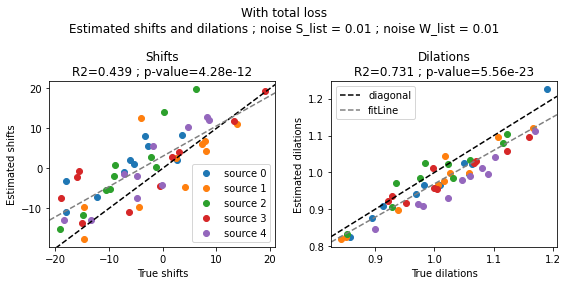

In [82]:
# colors
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

# scatter plots
plt.subplots(1, 2, figsize=(8, 4))

plt.subplot(1, 2, 1)
for i in range(p):
    plt.scatter(shifts[:, i], B[:, i], c=colors[i], label=f"source {i}")
plt.title(f"Shifts\nR2={r2_B:.3f} ; p-value={pvalue_B:.3}")
plt.xlabel("True shifts")
plt.ylabel("Estimated shifts")
plt.legend()
# diagonal
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()
plt.plot([xmin, xmax], [xmin, xmax], c='k', linestyle='--')
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
# fitLine
shifts_abs = np.linspace(xmin, xmax, 2)
fitLine_B = slope_B * shifts_abs + intercept_B
plt.plot(shifts_abs, fitLine_B, c="grey", linestyle='--')

plt.subplot(1, 2, 2)
for i in range(p):
    plt.scatter(dilations[:, i], A[:, i], c=colors[i])
plt.title(f"Dilations\nR2={r2_A:.3f} ; p-value={pvalue_A:.3}")
plt.xlabel("True dilations")
plt.ylabel("Estimated dilations")
# diagonal
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()
plt.plot([xmin, xmax], [xmin, xmax], c='k', linestyle='--', label="diagonal")
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
# fitLine
dilations_abs = np.linspace(xmin, xmax, 2)
fitLine_A = slope_A * dilations_abs + intercept_A
plt.plot(dilations_abs, fitLine_A, c="grey", linestyle='--', label="fitLine")
plt.legend()

plt.suptitle(f"With total loss\nEstimated shifts and dilations ; noise S_list = {noise_data} ; noise W_list = {noise_W_list}")
plt.tight_layout()
plt.show()

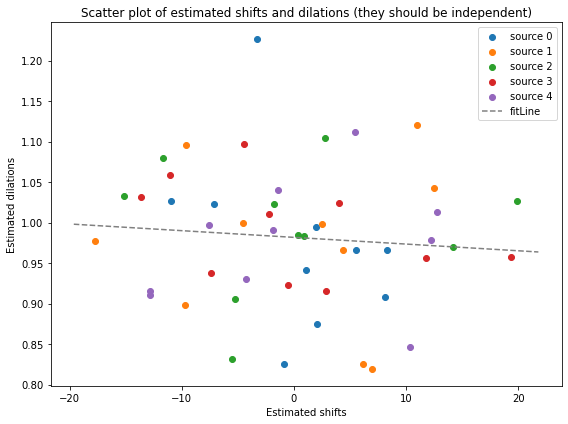

In [83]:
# dilations and shifts should be independent!
plt.figure(figsize=(8, 6))
for i in range(p):
    plt.scatter(B[:, i], A[:, i], c=colors[i], label=f"source {i}")
xmin, xmax = plt.xlim()
slope, intercept, _, _, _ = stats.linregress(B.ravel(), A.ravel())
fitLine = slope * np.linspace(xmin, xmax, 2) + intercept
plt.plot([xmin, xmax], fitLine, c="grey", linestyle='--', label="fitLine")
plt.xlabel("Estimated shifts")
plt.ylabel("Estimated dilations")
plt.title("Scatter plot of estimated shifts and dilations (they should be independent)")
plt.legend()
plt.tight_layout()
plt.show()

# zoom on a specific source

Zooming on a specific source can be useful when we observed strange points of a specific color in the first 2 scatter plots. The problem is often that, for this source, subjects have been splitted in 2 clusters. 

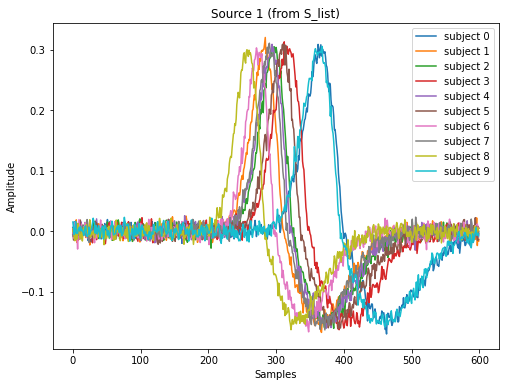

In [84]:
source_number = 1
plt.figure(figsize=(8, 6))
for i in range(m):
    plt.plot(S_list[i, source_number], label=f"subject {i}")
plt.legend()
# plt.plot(S_list[:, source_number].T)
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.title(f"Source {source_number} (from S_list)")
plt.show()

In [85]:
S_list_init = jnp.array([jnp.dot(W, X) for W, X in zip(W_list_init, X_list)])
Y_list_final = apply_both_delays_3d_cyclic(
    S_list, A=1/A, B=-B, max_shift=max_shift_2, 
    max_dilation=max_dilation_2, dilation_scale=1., t0=t0,
    shift_before_dilation=False,
)

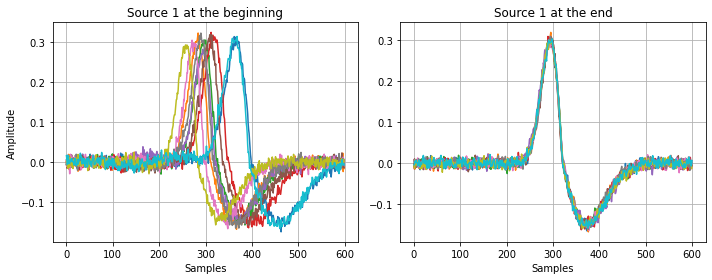

In [86]:
plt.subplots(1, 2, figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(S_list_init[:, source_number].T)
plt.title(f"Source {source_number} at the beginning")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(Y_list_final[:, source_number].T)
plt.title(f"Source {source_number} at the end")
plt.xlabel("Samples")
plt.grid()

plt.tight_layout()
plt.show()